<a href="https://colab.research.google.com/github/tonytarizzo/paddyRiceCompetition/blob/main/paddyCompetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai
!pip install timm

try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *
from fastai.vision.all import*
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.4 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
comp = 'paddy-disease-classification'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████| 1.02G/1.02G [00:58<00:00, 18.8MB/s]


In [5]:
path

Path('paddy-disease-classification')

In [6]:
from fastai.vision.all import *
set_seed(42)

path.ls()

(#4) [Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/train_images')]

In [7]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

In [8]:
from fastcore.parallel import *
from PIL import Image as PILImage

def f(o): return (o, PILImage.open(o).size)
sizes = parallel(f, files, n_workers=8)

incorrect_size_files = [f[0] for f in sizes if f[1] != (480, 640)]

def rotate_and_save(filepath):
    with PILImage.open(filepath) as img:
        rotated = img.rotate(90, expand=True)
        rotated.save(filepath)

parallel(rotate_and_save, incorrect_size_files, n_workers=8)

(#4) [None,None,None,None]

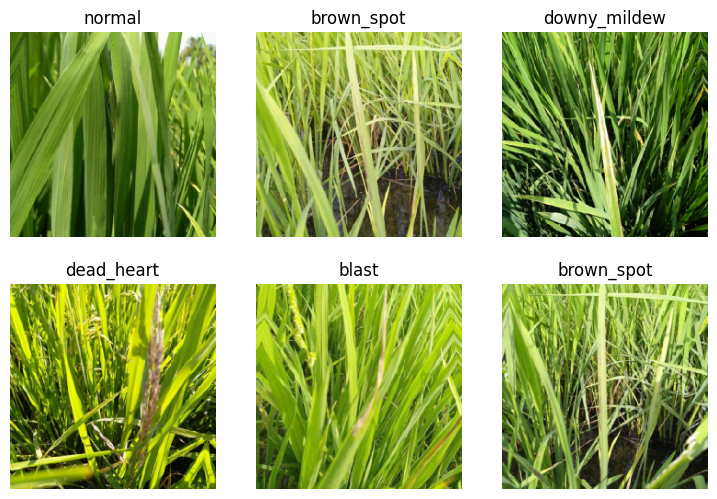

In [9]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
                                   #item_tfms=Resize((320,240)),
                                   batch_tfms=aug_transforms(size=224, min_scale=0.75))

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate, path='.').to_fp16()
#resnet26d#convnext_tiny#convnext_tiny_in22k

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


SuggestedLRs(valley=0.0006918309954926372, slide=0.00363078061491251)

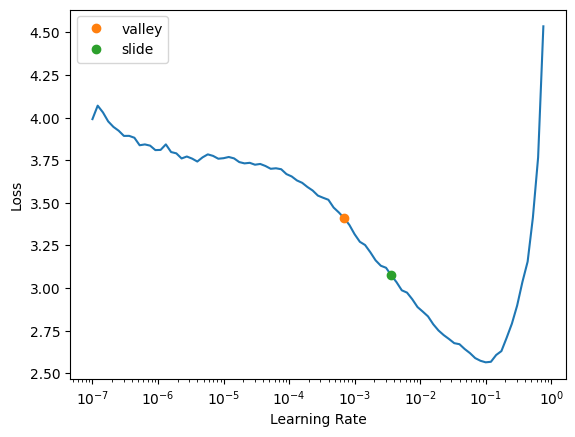

In [11]:
learn.lr_find(suggest_funcs=(valley, slide))

In [12]:
learn.fine_tune(12, 0.007)

epoch,train_loss,valid_loss,error_rate,time
0,1.064288,0.600414,0.197021,01:13


epoch,train_loss,valid_loss,error_rate,time
0,0.522034,0.309581,0.100913,01:33
1,0.384929,0.264544,0.088419,01:33
2,0.346899,0.247114,0.076886,01:34
3,0.252485,0.202635,0.063912,01:35
4,0.226920,0.245395,0.082172,01:34
5,0.160967,0.141479,0.038924,01:35
6,0.129947,0.120870,0.035079,01:33
7,0.093109,0.123877,0.036040,01:36
8,0.064542,0.124771,0.032196,01:34
9,0.052487,0.104652,0.027391,01:34


In [13]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [14]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

In [16]:
sizes_tst = parallel(f, tst_files, n_workers=8)
incorrect_size_tst_files = [f[0] for f in sizes_tst if f[1] != (480, 640)]
parallel(rotate_and_save, incorrect_size_tst_files, n_workers=8)
tta_probs, tta_targs = learn.tta(dl=tst_dl)
tta_idxs = tta_probs.argmax(dim=1)

tta_idxs

tensor([7, 8, 3,  ..., 8, 1, 5])

In [17]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [18]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(tta_idxs.numpy(), name="tta_idxs").map(mapping)
results

0                       hispa
1                      normal
2                       blast
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: tta_idxs, Length: 3469, dtype: object

In [19]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [21]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

100%|██████████| 70.4k/70.4k [00:02<00:00, 30.4kB/s]
